In [5]:
! pip install langchain
! pip install langgraph
! pip install langchain_community
! pip install langchain_google_genai


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
! pip install python-dotenv



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
! pip install psycopg2-binary



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
from langchain.sql_database import SQLDatabase
# from langchain_experimental.sql import SQLDatabaseChain
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.graph import END, StateGraph, START
from typing import Annotated, Literal, TypedDict
from typing import Any
from langgraph.types import Command # LangGraph types for extending commands and functionalities
from pydantic import BaseModel, Field  # `BaseModel` is the base class used to create data models, `Field` is used to provide additional metadata
from langchain_core.messages import HumanMessage # Human message classes for handling human messages in LangChain
from langchain_community.tools.tavily_search import TavilySearchResults # TavilySearchResults for handling external search results
from langgraph.prebuilt import create_react_agent # Prebuilt tools and agents for streamlined development
from langchain.tools import Tool
from langchain_core.tools import tool


In [9]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

load_dotenv()

# Access the API key from the environment
api_key = os.getenv("GOOGLE_API_KEY")

# Optionally, you can still set it to `os.environ` if required by the library
os.environ["GOOGLE_API_KEY"] = api_key

# Initialize the model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm.invoke("hi")

c:\Users\ayush\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bfce0f8e-9f54-425c-9895-4ea5385bb60b-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [10]:

database_url = os.getenv("DATABASE_URL")
db = SQLDatabase.from_uri(database_url)
from langchain_community.agent_toolkits import SQLDatabaseToolkit
toolkit=SQLDatabaseToolkit(db=db,llm=llm)
tools=toolkit.get_tools()
list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)

In [11]:
@tool
def multiply(num1: float, num2: float) -> float:
  '''
  Multiplies two numbers and returns the result.
  Only use this tool for multiplication. Do not use it for division or other operations.
  multiply tool for multiplying 2 numbers .
  Args:
  num1: The first number to be multiplied.
  num2: The Second number to be multiplied.
  Returns:
  Command: A number which is multiplication answer of inputs.
  '''
  return num1*num2

@tool
def db_exec_tool(query : str)-> str:
    """
    Execute a SQL query against the database and return the result.
    If the query is invalid or returns no result, an error message will be returned.
    In case of an error, the user is advised to rewrite the query and try again.
    """
    # Remove ```sql and ``` if present
    query = query.replace("```sql", "").replace("```", "").strip()

    print("Executing query:")
    print(query)

    result = db.run_no_throw(query)

    print("Query result:")
    # print(result)
    return {"result": result}


In [12]:
class QueryChecker(BaseModel):
    query: str = Field(
        description="The corrected postgres query generated by the LLm"
    )


In [13]:
def query_gen(state: MessagesState)-> Command[Literal[ "query_check"]]:
    """
    Query Generation Node to convert natural language database queries into PostgreSQL queries.

    Args:
        state (MessagesState): The current state containing the conversation history with a natural language database query.

    Returns:
        Command: A command to update the state with the generated PostgreSQL query.
    """
    # print("query_generator")
    # print(state["messages"][-1].content)

    list_tables_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)
    get_schema_tool = next((tool for tool in tools if tool.name == "sql_db_schema"), None)

    if not list_tables_tool or not get_schema_tool:
        raise ValueError("Required database tools (list_tables_tool, get_schema_tool) are not available")

    query_agent = create_react_agent(
            llm,  # The language model instance used by the agent
            tools=[list_tables_tool, get_schema_tool],  # List of database tools the agent can utilize
            state_modifier=(
                "You are an expert database query generator specialized in PostgreSQL. "
                "You are provided with tools to list the tables in the database and get the schema of specific tables. "
                "Always use the list_tables_tool first to get an overview of available tables. "
                "Then, for any relevant table(s), use the get_schema_tool to retrieve their schema before constructing the query. "
                "Ensure that the SQL query you generate is syntactically correct and follows PostgreSQL standards. "
                "Your final output should only be the SQL query, without any additional explanation or commentary."
                "If empty response is returned by database ,deal accordingly by telling that to user"
            )
        )


    # Example of how the agent might be invoked (depends on the exact agent framework you use)
    result = query_agent.invoke(state)
    # print(result)
    return Command(
     update={
        "messages": [
            # Append the reason (supervisor's response) to the state, tagged with "supervisor"
            HumanMessage(content=result["messages"][-1].content, name="supervisor")
        ]
    },
    goto="query_check",  # Specify the next node in the workflow
  )




In [14]:
def query_check(state: MessagesState)-> Command[Literal["query_execute"]]:
    """
    This tool checks if the provided SQL query is correct.
    If incorrect, it returns the corrected query; otherwise, it returns the original query.
    """
    query_check_system = """You are a SQL expert with a strong attention to detail.
    You work with PostgreSQL, SQLite, and other relational databases.
    Your task is to carefully review the provided SQL query for any mistakes, including:
    - Quoting identifiers correctly (e.g., "Snippet" vs Snippet in PostgreSQL)
    - Data type mismatches
    - Using the correct number of arguments in functions
    - Ensuring joins use valid columns
    - Checking for NULL handling issues
    - Ensuring correct usage of UNION vs UNION ALL
    - Proper casting and type usage
    Make sure that the final query is in a postgres acceptable format
    If there is an issue, respond with the **corrected query only**.
    If the query is already correct, simply return the **original query**.
    """
    query = state["messages"][-1].content

    full_prompt = f"{query_check_system}\n\nQuery:\n{query}"

    # LLM invocation
    response = llm.with_structured_output(QueryChecker).invoke(full_prompt)

    print("query_Check")
    print(response)
    return Command(
     update={
        "messages": [
            # Append the reason (supervisor's response) to the state, tagged with "supervisor"
            HumanMessage(content=response.query, name="supervisor")
        ]
    },
    goto="query_execute",  # Specify the next node in the workflow
  )




In [15]:

class QueryExecutor(BaseModel):
   query: str = Field(description="The final output in human readable format")

In [16]:
def query_execute(state : MessagesState):
  """
    This tool executes the provided SQL query and return the response.
    It returns the response in simple human understandable format.
  """
  # print("state from query execute")
  # print(state)
  executing_agent = create_react_agent(
          llm,  # The language model instance used by the agent
          tools=[db_exec_tool],  # List of database tools the agent can utilize
          state_modifier=(
              "You are an expert PostgreSQL query executor. "
              "you can use db_exec_tool for execution of sql query"
              "Your primary task is to execute the provided SQL query accurately and return the result. "
              "Ensure that the query is executed against the database without modification, and the response is returned in a clear, human-understandable format. "
              "Do not generate new queries, retrieve schemas, or list tables unless explicitly asked. "
              "Your output should only contain the query execution result in a human readable manner with some explanation or commentary."
              "Make sure that you show user the response and not just explanation of response"
          ),

      )

  final_result = executing_agent.invoke(state)
  # parsed_result = QueryExecutor(result=final_result)  # Assuming `QueryExecutor` is a Pydantic model with a 'result' field
  # print(parsed_result)
  print(final_result["messages"][-1].content)



In [17]:
builder = StateGraph(MessagesState)


builder.add_node("query_gen", query_gen)  # Add the supervisor node to the graph
# Add task-specific nodes for various roles in the multi-agent system
 # Node for managing coding and analytical tasks
builder.add_node("query_check", query_check)  # Add the supervisor node to the graph
builder.add_node("query_execute", query_execute)  # Add the supervisor node to the graph

# Add edges and nodes to define the workflow of the graph
builder.add_edge(START, "query_gen")  # Connect the start node to the supervisor node
# Compile the graph to finalize its structure
graph = builder.compile()

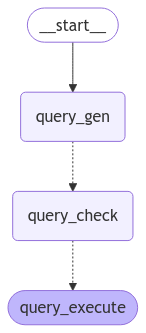

In [18]:
from IPython.display import Image, display # Import for displaying images in a Jupyter Notebook

display(Image(graph.get_graph(xray=True).draw_mermaid_png())) # Display the graph's PNG representation


In [19]:
import pprint

inputs = {
    "messages": [
        ("user", "How many guest users do we have in the database?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        # pprint.pprint(f"Output from node '{key}':")
        # pprint.pprint(value, indent=2, width=80, depth=None)


query_Check
query='SELECT\n  COUNT(*)\nFROM\n  "User"\nWHERE\n  "isGuest" = TRUE;'
Executing query:
SELECT
  COUNT(*)
FROM
  "User"
WHERE
  "isGuest" = TRUE;
Query result:
The query `SELECT COUNT(*) FROM "User" WHERE "isGuest" = TRUE;` was executed successfully.  The result shows that there are 5 guest users in the database.
